# **ML project : (BO1)Prédiction des Livraisons en Retard (CRISP-DM etapes)**


## **Buisness Understanding**

# Étape 1 – **Business Understanding (BO1 / DSO1)**

## **Objectif métier (Business Objective – BO1)**

Réduire le nombre de livraisons en retard.


## **Objectif Data Science (DSO1)**
Construire un modèle de classification qui prédit si une commande sera livrée à l’heure ou en retard.

Construire un **modèle de classification supervisée** qui prédit si une commande sera livrée à l’heure ou en retard.

- `0` = **livrée à l’heure**  
- `1` = **livrée en retard**

Cela permettra :
- d’**anticiper les retards**
- de **mettre en place des actions préventives** (ex. assigner plus de livreurs, ajuster les délais communiqués au client)

## **Variable cible**

- `is_late = 1` si `delivery_duration > seuil` (par ex. **10 minutes**)  
- `is_late = 0` sinon

**Où** :  
`delivery_duration = actual_delivery_time - created_at`

## **Critères de succès**

### **Métriques de performance**

- **F1-score ≥ 0.75** (classe "retard")
- **Recall élevé** (ne pas rater trop de retards)
- **Comparaison avec baseline naïve** ("tout à l’heure")

### **Critères métier**

- Permettre aux **managers logistiques** de savoir **en temps réel** quelles commandes risquent d’être en retard
- Fournir un **outil d’aide à la décision** (ex. tableau de bord, API)


## **Data understanding**

In [3]:
import numpy as np
#Pour afficher la version de  numpy
print(f"numpy version {np.__version__}")

import pandas as pd
# Pour afficher la version de pandas
print(f"pandas version {pd.__version__}")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import isnan
from pandas import read_csv

numpy version 2.1.3
pandas version 2.2.3


In [4]:
from pathlib import Path

cwd = Path.cwd()
print("Dossier courant:", cwd)
print("\nFichiers CSV visibles ici:")
for p in sorted(cwd.glob("*.csv")):
    print(" -", p.name)


Dossier courant: C:\Users\inesc\Documents\MiniproMl

Fichiers CSV visibles ici:
 - data_clean_for_model.csv
 - datadelevry.csv


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Chemin à adapter
df = pd.read_csv("datadelevry.csv")

# Aperçu rapide
print(df.shape)
print(df.head())
display(df.head(3))


(172941, 14)
   market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:27:16   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:56:29   
2        3.0  2015-01-22 20:39:28  2015-01-22 21:09:09   
3        3.0  2015-02-03 21:21:45  2015-02-03 22:13:00   
4        3.0  2015-02-15 02:40:36  2015-02-15 03:20:26   

                           store_id store_primary_category  order_protocol  \
0  df263d996281d984952c07998dc54358               american             1.0   
1  f0ade77b43923b38237db569b016ba25                mexican             2.0   
2  f0ade77b43923b38237db569b016ba25                    NaN             1.0   
3  f0ade77b43923b38237db569b016ba25                    NaN             1.0   
4  f0ade77b43923b38237db569b016ba25                    NaN             1.0   

   total_items  subtotal  num_distinct_items  min_item_price  max_item_price  \
0          4.0    3441.0                 4.0           557.0          1239.0   
1        

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4.0,3441.0,4.0,557.0,1239.0,NaN,14.0,21.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NaN,1.0,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0


In [6]:
# Parser les dates
df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")
df["actual_delivery_time"] = pd.to_datetime(df["actual_delivery_time"], errors="coerce")

# Calcul de la durée en minutes
df["delivery_duration_minutes"] = (
    (df["actual_delivery_time"] - df["created_at"]).dt.total_seconds() / 60.0
)

# Seuil métier pour le retard (à ajuster si besoin)
LATE_THRESHOLD_MIN = 10

# Variable cible binaire
df["is_late"] = (df["delivery_duration_minutes"] > LATE_THRESHOLD_MIN).astype("Int64")

# Features temporelles
df["day_of_week"] = df["created_at"].dt.dayofweek
df["hour_of_day"] = df["created_at"].dt.hour

# Sanity checks de base
print("Durées négatives:", (df["delivery_duration_minutes"] < 0).sum())
print("Durées manquantes:", df["delivery_duration_minutes"].isna().sum())
print("Cible manquante:", df["is_late"].isna().sum())



Durées négatives: 0
Durées manquantes: 6797
Cible manquante: 0


In [7]:
# Valeurs manquantes par colonne
na_counts = df.isna().sum().sort_values(ascending=False)
display(na_counts.to_frame("missing_values"))

# Doublons
print("Doublons de lignes exactes:", df.duplicated().sum())

# Types
display(df.dtypes)


,missing_values
total_busy_partners,17351
total_onshift_partners,17328
total_outstanding_orders,17317
store_primary_category,7572
delivery_duration_minutes,6797
order_protocol,4310
market_id,4287
total_items,3488
min_item_price,3469
actual_delivery_time,3467


Doublons de lignes exactes: 105


market_id                           float64
created_at                   datetime64[ns]
actual_delivery_time         datetime64[ns]
store_id                             object
store_primary_category               object
order_protocol                      float64
total_items                         float64
subtotal                            float64
num_distinct_items                  float64
min_item_price                      float64
max_item_price                      float64
total_onshift_partners              float64
total_busy_partners                 float64
total_outstanding_orders            float64
delivery_duration_minutes           float64
is_late                               Int64
day_of_week                         float64
hour_of_day                         float64
dtype: object

In [8]:
# Colonnes numériques d'intérêt
numeric_cols = [
    "delivery_duration_minutes", "total_items", "subtotal", "num_distinct_items",
    "min_item_price", "max_item_price", "total_onshift_partners",
    "total_busy_partners", "total_outstanding_orders", "day_of_week", "hour_of_day"
]

# Stats numériques
display(df[numeric_cols].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).T)

# Catégorielles principales (top 10)
categorical_cols = ["store_primary_category", "order_protocol", "market_id"]
for c in categorical_cols:
    if c in df.columns:
        print(f"\nTop 10 {c}:")
        display(df[c].astype(str).value_counts().head(10))


,count,mean,std,min,1%,5%,50%,95%,99%,max
delivery_duration_minutes,166144.0,48.653734,348.927631,1.683333,19.233333,24.9,44.416667,81.283333,108.2595,141947.65
total_items,169453.0,3.201543,2.674022,1.000000,1.000000,1.0,3.000000,7.000000,12.0000,411.00
subtotal,169660.0,2684.534174,1824.565715,0.000000,525.000000,800.0,2200.000000,6210.000000,9487.6400,27100.00
num_distinct_items,169489.0,2.678699,1.634766,1.000000,1.000000,1.0,2.000000,6.000000,8.0000,20.00
min_item_price,169472.0,684.503009,520.492937,-86.000000,0.000000,125.0,595.000000,1595.000000,2499.0000,14700.00
max_item_price,169521.0,1159.144708,560.203570,0.000000,259.000000,429.0,1095.000000,2100.000000,3095.0000,14700.00
total_onshift_partners,155613.0,44.813216,34.536004,-3.000000,0.000000,4.0,37.000000,115.000000,136.0000,171.00
total_busy_partners,155590.0,41.809801,32.187008,-5.000000,0.000000,3.0,34.000000,105.000000,126.0000,154.00
total_outstanding_orders,155624.0,58.090224,52.728748,-6.000000,0.000000,3.0,41.000000,169.000000,213.0000,285.00
day_of_week,169541.0,3.219327,2.045736,0.000000,0.000000,0.0,3.000000,6.000000,6.0000,6.00



Top 10 store_primary_category:


store_primary_category
american    16736
pizza       14916
mexican     14005
burger       9909
japanese     8242
sandwich     8213
chinese      8038
nan          7572
dessert      7182
italian      6424
Name: count, dtype: int64


Top 10 order_protocol:


order_protocol
1.0    47283
3.0    46456
5.0    35922
2.0    21381
4.0    16952
nan     4310
6.0      618
7.0       19
Name: count, dtype: int64


Top 10 market_id:


market_id
2.0    46720
4.0    41251
1.0    32847
3.0    19889
5.0    15644
6.0    12303
nan     4287
Name: count, dtype: int64

In [9]:
target_counts = df["is_late"].value_counts(dropna=False)
target_rate = df["is_late"].mean()
print("Répartition de la cible (is_late):")
display(target_counts.to_frame("count"))
print(f"Taux de retard: {target_rate:.3f}")


Répartition de la cible (is_late):


,count
is_late,
1,166119
0,6822


Taux de retard: 0.961


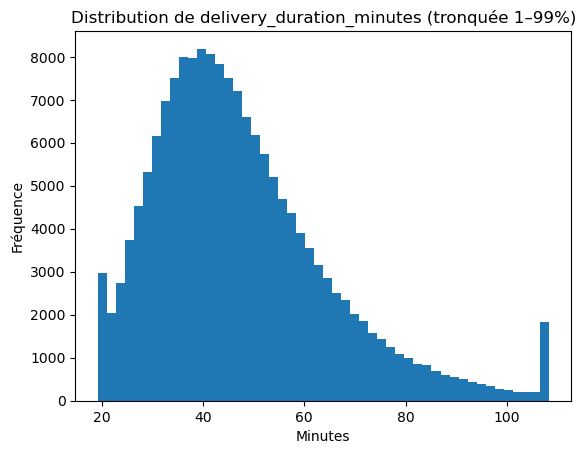

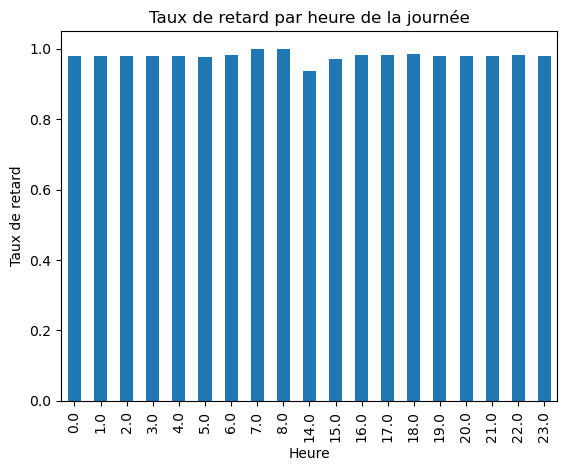

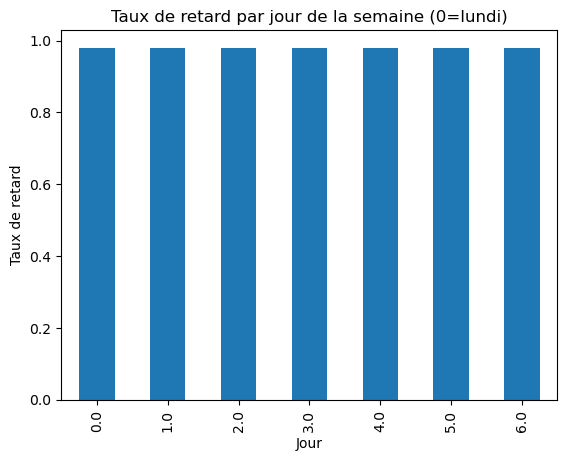

In [10]:
# Histogramme de la durée de livraison (winsorisation simple pour lisibilité)
dur = df["delivery_duration_minutes"].dropna()
p1, p99 = np.percentile(dur, [1, 99])
dur_clip = dur.clip(lower=p1, upper=p99)

plt.figure()
plt.hist(dur_clip, bins=50)
plt.title("Distribution de delivery_duration_minutes (tronquée 1–99%)")
plt.xlabel("Minutes")
plt.ylabel("Fréquence")
plt.show()

# Bar chart: taux de retard par heure
late_by_hour = df.groupby("hour_of_day")["is_late"].mean().sort_index()
plt.figure()
late_by_hour.plot(kind="bar")
plt.title("Taux de retard par heure de la journée")
plt.xlabel("Heure")
plt.ylabel("Taux de retard")
plt.show()

# Bar chart: taux de retard par jour de semaine (0=lundi)
late_by_dow = df.groupby("day_of_week")["is_late"].mean().sort_index()
plt.figure()
late_by_dow.plot(kind="bar")
plt.title("Taux de retard par jour de la semaine (0=lundi)")
plt.xlabel("Jour")
plt.ylabel("Taux de retard")
plt.show()


In [11]:
# Par catégorie de magasin
if "store_primary_category" in df.columns:
    late_by_cat = (
        df.groupby("store_primary_category")["is_late"]
          .agg(["mean", "count"])
          .sort_values("mean", ascending=False)
    )
    display(late_by_cat.head(15))

# Par protocole de commande
if "order_protocol" in df.columns:
    late_by_proto = (
        df.groupby("order_protocol")["is_late"]
          .agg(["mean", "count"])
          .sort_values("mean", ascending=False)
    )
    display(late_by_proto)

# Par marché
if "market_id" in df.columns:
    late_by_market = (
        df.groupby("market_id")["is_late"]
          .agg(["mean", "count"])
          .sort_values("mean", ascending=False)
    )
    display(late_by_market.head(15))


,mean,count
store_primary_category,,
african,1.0,10
belgian,1.0,2
alcohol-plus-food,1.0,1
russian,1.0,15
comfort-food,1.0,28
lebanese,1.0,9
moroccan,1.0,25
ethiopian,0.991525,118
southern,0.985612,139


,mean,count
order_protocol,,
7.0,1.0,19
2.0,0.96235,21381
1.0,0.961043,47283
4.0,0.960418,16952
3.0,0.960328,46456
5.0,0.959607,35922
6.0,0.959547,618


,mean,count
market_id,,
1.0,0.961397,32847
3.0,0.961386,19889
2.0,0.960552,46720
6.0,0.960172,12303
5.0,0.959857,15644
4.0,0.95954,41251


,delivery_duration_minutes,total_onshift_partners,total_busy_partners,total_outstanding_orders
delivery_duration_minutes,1.000000,0.059618,0.075851,0.145907
total_onshift_partners,0.059618,1.000000,0.943849,0.935977
total_busy_partners,0.075851,0.943849,1.000000,0.932750
total_outstanding_orders,0.145907,0.935977,0.932750,1.000000


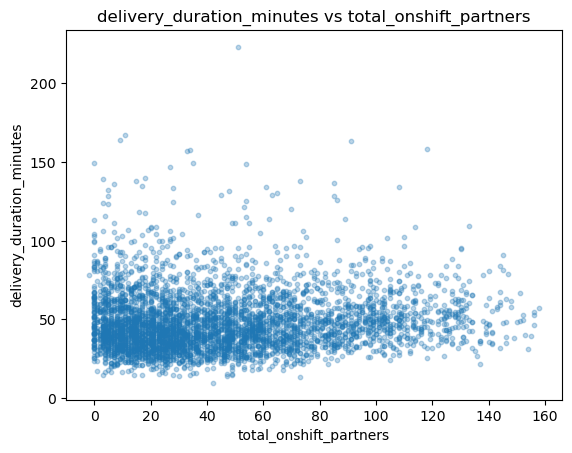

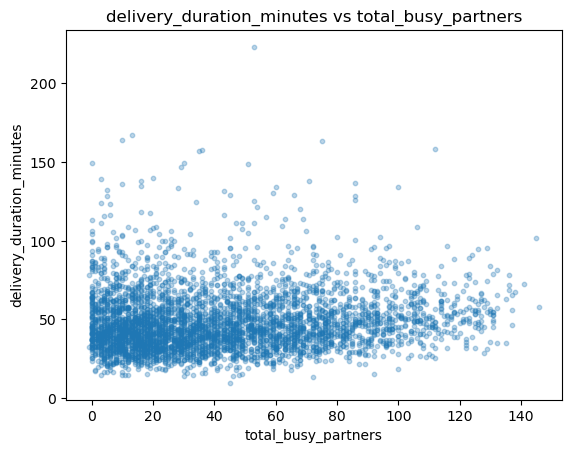

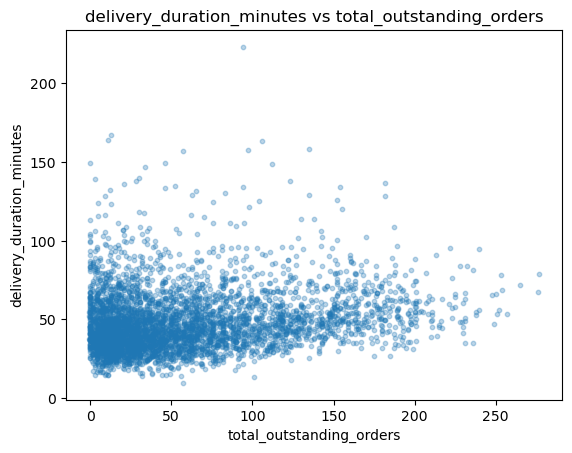

In [12]:
cols_capacity = ["total_onshift_partners", "total_busy_partners", "total_outstanding_orders"]
available_cols = [c for c in cols_capacity if c in df.columns]

# Corrélations simples avec la durée
if available_cols:
    corr_df = df[["delivery_duration_minutes"] + available_cols].corr()
    display(corr_df)

# Scatter plots simples (échantillon pour performance)
sample = df.sample(min(len(df), 5000), random_state=42) if len(df) > 5000 else df

for c in available_cols:
    plt.figure()
    plt.scatter(sample[c], sample["delivery_duration_minutes"], alpha=0.3, s=10)
    plt.title(f"delivery_duration_minutes vs {c}")
    plt.xlabel(c)
    plt.ylabel("delivery_duration_minutes")
    plt.show()


In [13]:
# Optionnel: retirer lignes non valides pour la suite du projet
df_clean = df.dropna(subset=["created_at", "actual_delivery_time", "delivery_duration_minutes", "is_late"]).copy()
df_clean = df_clean[df_clean["delivery_duration_minutes"] >= 0]  # on enlève durées négatives

# Sauvegarde pour Data Preparation / Modeling
df_clean.to_csv("data_clean_for_model.csv", index=False)
print(df_clean.shape)


(166144, 18)


## **Data Preparation**

Étape de préparation des données avant l’entraînement du modèle.

Création de la variable cible is_late (0 = à l’heure, 1 = en retard).

Extraction de features temporelles (day_of_week, hour_of_day).

Sélection des variables catégorielles et numériques.

Encodage des variables catégorielles (OneHotEncoder).

Normalisation des variables numériques (StandardScaler).

Séparation du dataset en ensembles d’entraînement et de test.


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# On part du DataFrame df obtenu après Data Understanding

# 0) Parsing des dates (robuste)
df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")
df["actual_delivery_time"] = pd.to_datetime(df["actual_delivery_time"], errors="coerce")

# 1) Calcul de la durée de livraison (en minutes)
df["delivery_duration_minutes"] = (
    (df["actual_delivery_time"] - df["created_at"]).dt.total_seconds() / 60.0
)

# 2) Nettoyage minimal: enlever lignes invalides (dates/durée manquantes ou durée négative)
df = df.dropna(subset=["created_at", "actual_delivery_time", "delivery_duration_minutes"]).copy()
df = df[df["delivery_duration_minutes"] >= 0].copy()

# 3) Création de la variable cible (retard si > 10 min)
SEUIL_RETARD = 10
df["is_late"] = (df["delivery_duration_minutes"] > SEUIL_RETARD).astype(int)

# 4) Extraction des variables temporelles
df["day_of_week"] = df["created_at"].dt.dayofweek  # 0 = lundi, 6 = dimanche
df["hour_of_day"] = df["created_at"].dt.hour

# 5) Définition des features
categorical_features = ["store_primary_category", "order_protocol", "market_id"]
numeric_features = [
    "total_items", "subtotal", "num_distinct_items", "min_item_price",
    "max_item_price", "total_onshift_partners", "total_busy_partners",
    "total_outstanding_orders", "day_of_week", "hour_of_day"
]

# 6) X / y
X = df[categorical_features + numeric_features].copy()
y = df["is_late"].copy()

# 7) Split train/test (stratifié)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Taille train:", X_train.shape, "Taille test:", X_test.shape)

# 8) Préprocesseur avec IMPUTATION (évite l'erreur 'Input X contains NaN')
#   - Catégorielles: imputation 'most_frequent' + OneHot
#   - Numériques: imputation 'median' + StandardScaler
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_features),
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features)
    ]
)

print("Data Preparation OK: X_train, X_test, y_train, y_test et 'preprocessor' prêts.")


Taille train: (132915, 13) Taille test: (33229, 13)
Data Preparation OK: X_train, X_test, y_train, y_test et 'preprocessor' prêts.


# **Modeling**

Dans cette étape, on entraîne différents modèles de classification supervisée.

Modèles de base : Logistic Regression (baseline simple, interprétable).

Modèles plus puissants : Random Forest, XGBoost.

Les données passent par le pipeline de Data Preparation (encodage et normalisation).

On compare les modèles en utilisant la même séparation train/test.

1) Logistic Regression (baseline)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Pipeline Logistic Regression
log_reg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

# Entraînement
log_reg.fit(X_train, y_train)

print("Logistic Regression entraîné.")


Logistic Regression entraîné.


2) Random Forest Classifier

In [17]:
from sklearn.ensemble import RandomForestClassifier

# Pipeline Random Forest
rf_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42
    ))
])

rf_clf.fit(X_train, y_train)

print("Random Forest entraîné.")


Random Forest entraîné.


3) XGBoost Classifier

In [20]:
from xgboost import XGBClassifier

# Pipeline XGBoost
xgb_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss"
    ))
])

xgb_clf.fit(X_train, y_train)

print("XGBoost entraîné.")


D:\4DS\ML\anac\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:46:05] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost entraîné.


# **Evaluation**

Dans cette étape, on évalue les modèles entraînés :

Métriques principales : Accuracy, Precision, Recall, F1-score.

Outils de visualisation : matrice de confusion, courbe ROC et courbe précision-rappel.

Comparaison des trois modèles pour choisir le plus adapté.

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt


In [22]:
def evaluate_model(model, X_test, y_test, name="Model"):
    # Prédictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Métriques
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"--- {name} ---")
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1-score : {f1:.3f}")

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"Matrice de confusion - {name}")
    plt.show()

    # Courbe ROC
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("Taux faux positifs (FPR)")
        plt.ylabel("Taux vrais positifs (TPR)")
        plt.title("Courbe ROC")
        plt.legend()
        plt.show()

        # Courbe Précision-Rappel
        precs, recs, _ = precision_recall_curve(y_test, y_proba)
        plt.plot(recs, precs, label=name)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Courbe Précision-Rappel")
        plt.legend()
        plt.show()


--- Logistic Regression ---
Accuracy : 1.000
Precision: 1.000
Recall   : 1.000
F1-score : 1.000


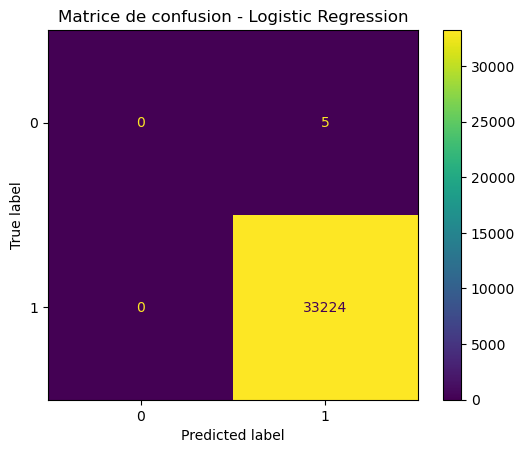

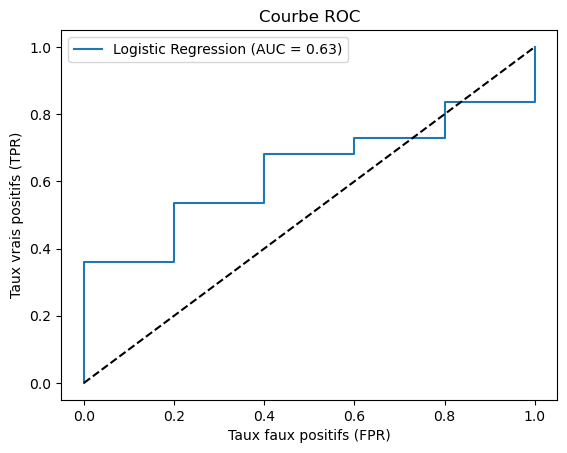

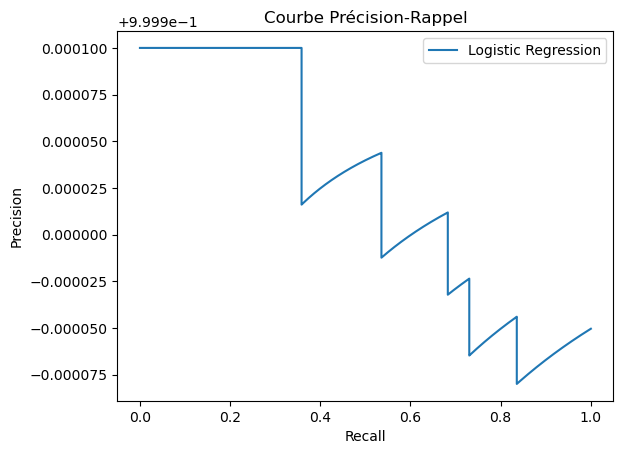

--- Random Forest ---
Accuracy : 1.000
Precision: 1.000
Recall   : 1.000
F1-score : 1.000


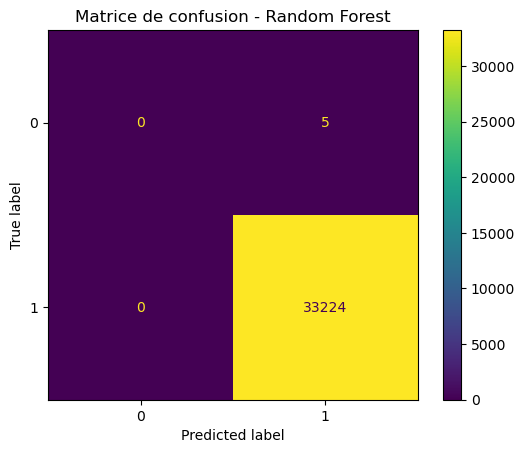

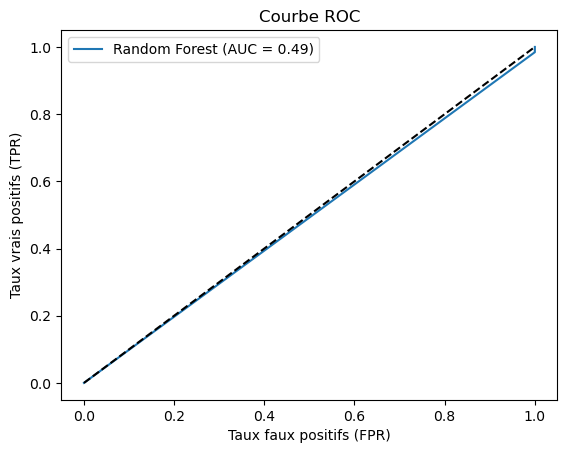

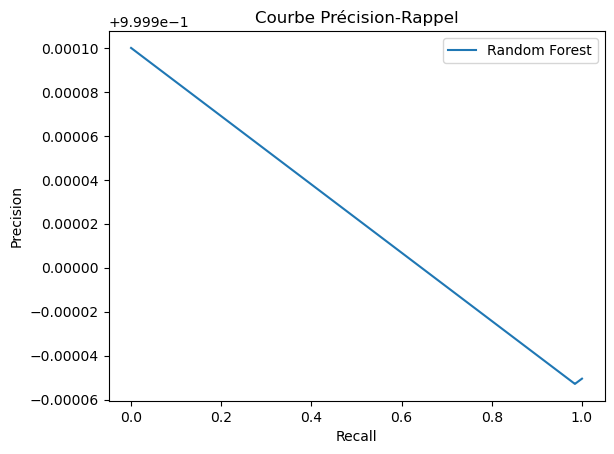

AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [23]:
evaluate_model(log_reg, X_test, y_test, name="Logistic Regression")
evaluate_model(rf_clf, X_test, y_test, name="Random Forest")
evaluate_model(xgb_clf, X_test, y_test, name="XGBoost")
